In [31]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import torch
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import imageio
import os
import random

import Pablos_Agent.utils.stats_functions as sf
from Pablos_Agent.Agent import Dueling_DDQN_Agent
from Pablos_Agent.utils.actions import MORE_ACTIONS
from Pablos_Agent.utils import help_classes as hc

In [32]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291, 292, 293, 294, 295]
seed = SEED_TRAIN_1

## Training the Agent: SEED 1

In [33]:
env_name = "Noisy_Pendulum-v1"
env = gym.make("Pendulum-v1", render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)

# Initialize the agent with the correct state/action space
state_space = env.observation_space
action_space = env.action_space

Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Network loaded from Noisy_Pendulum-v1/weights/episode_2400.pth


/home/pablosbl/Documents/GitHub/hockey-en-mallorca/src/hockey-env/Pablo_noisy_net/QFunction.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.l

In [34]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Ensure deterministic behavior in CUDA if available
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#env_name = "CartPole-v1"
env_name = "Noisy_Pendulum-v1"
env = gym.make("Pendulum-v1", render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)

# Initialize the agent with the correct state/action space
state_space = env.observation_space
action_space = env.action_space
agent = Dueling_DDQN_Agent(
    state_space,
    action_space,
    seed = seed,
    use_eps_decay = False,
    use_dueling = True,
    use_double = True,
    use_noisy = True,
    hidden_sizes = [256, 256]
)

stats = []
losses = []

max_episodes = 4000
max_steps = 1000
train_iterations = 32  # Number of training steps per episode

for episode in range(max_episodes):

    state = env.reset(seed = seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility
    total_reward = 0
    
    for t in range(max_steps):
        done = False
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        
        total_reward += reward

        agent.buffer.add_transition((state, action, reward, next_state, done))      # Store transition in the agent"s memory and then train

        state = next_state

        if done: break
        
    losses.extend(agent.train(train_iterations))
    stats.append([episode, total_reward, t + 1])
    
    if agent._config["use_eps_decay"] and episode > int(0.5 * max_episodes):
        agent._perform_epsilon_decay()

    print(f"Episode {episode+1}/{max_episodes}, Total Reward: {total_reward}")
        
    if ((episode) % int(max_episodes/10) == 0) and episode > 0:
        agent.Q.save(env_name, name = f"episode_{episode}")

agent.Q.save(env_name, name = "training_finished")
sf.save_stats(env_name, stats, losses)

Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Episode 1/4000, Total Reward: -7093.742728077886
Episode 2/4000, Total Reward: -7342.540984930669
Episode 3/4000, Total Reward: -7111.61603549148
Episode 4/4000, Total Reward: -7111.61603549148
Episode 5/4000, Total Reward: -7111.61603549148
Episode 6/4000, Total Reward: -7111.61603549148
Episode 7/4000, Total Reward: -7105.686632585852
Episode 8/4000, Total Reward: -7111.61603549148
Episode 9/4000, Total Reward: -7105.686632585852
Episode 10/4000, Total Reward: -5953.2464550878885
Episode

KeyboardInterrupt: 

In [35]:
# OPTIONAL
agent = Dueling_DDQN_Agent(
    state_space,
    action_space,
    seed = SEED_TRAIN_1,
    use_eps_decay = False,
    use_dueling = True,
    use_double = True,
    use_noisy = True,
    hidden_sizes = [256, 256]
)
agent.Q.load(env_name)
stats, losses = sf.load_stats(env_name)

Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (3)
  Hidden Layer 1: Linear(3, 256) -> ReLU
  Hidden Layer 2: Linear(256, 256) -> ReLU
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 5)
------------------------------------------------------
Network loaded from Noisy_Pendulum-v1/weights/training_finished.pth


Plot saved at Noisy_Pendulum-v1/stats/plots/returns_plot.png


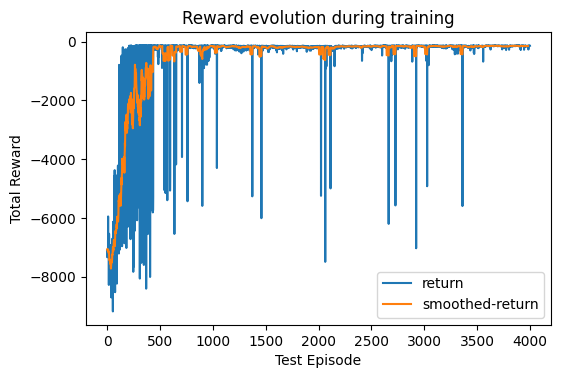

In [36]:
sf.plot_returns(stats, env_name)

Plot saved at Noisy_Pendulum-v1/stats/plots/losses_plot.png


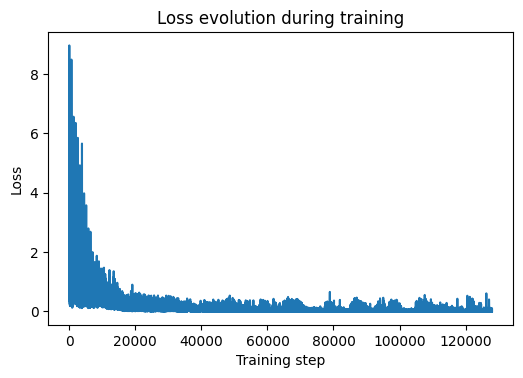

In [37]:
sf.plot_losses(losses, env_name)

## Testing the Agent

Test Episode 1, Total Reward: -163.14181485092809
Test Episode 2, Total Reward: -282.634271020664
Test Episode 3, Total Reward: -279.6316544125427
Test Episode 4, Total Reward: -283.47872776987396
Test Episode 5, Total Reward: -400.93295210183294
Plot saved at Noisy_Pendulum-v1/stats/plots/test_results.png


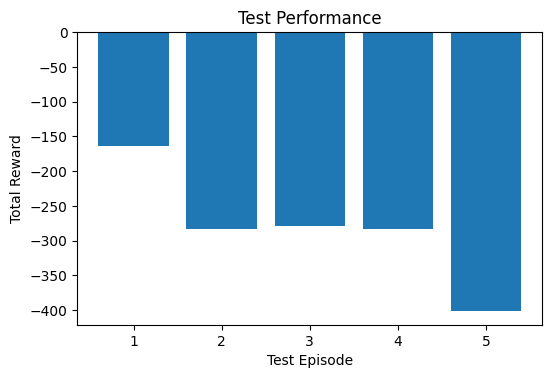

In [30]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

max_steps = 1000

for episode in range(test_episodes):
    state = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state
    done = False
    total_reward = 0
    frames = []
    
    for t in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)
        action = agent.act(state, validation = True)  # Fully greedy policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

        if done: break
    
    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)